# Dzitri Check is a web robot to prevent fake news, misinformation and radical propagandists on social media platforms. 

This first prototype has been developed during the Connective Cities Hackathon of the 18-20 November 2020, answering to a call for solutions related to the cities of Lomé, Togo and Antananarivo, Madagascar, two French-speaking countries.

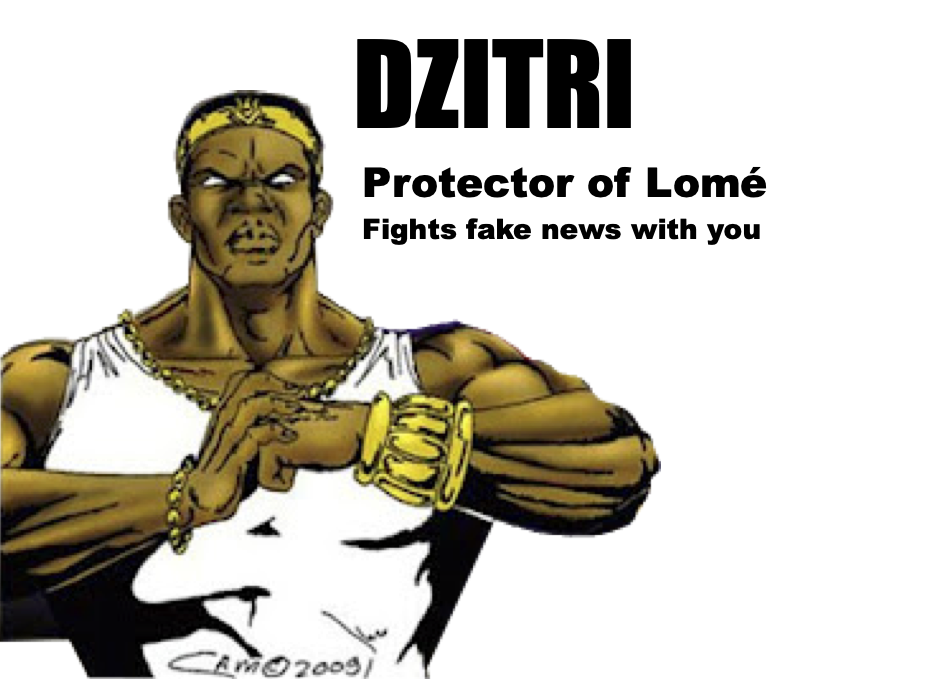

In [19]:
from IPython import display
display.Image("./dzitri.png")

In [1]:
#basic tasks
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#nlp libraries
import string
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer

#web app
import streamlit as st
import joblib,os

In [12]:
# import fakenews dataset
data = pd.read_csv("/Users/juliencarbonnell/Desktop/fakenews_FR.csv", sep=';')

In [13]:
data.head()

,media,post,fake
0,unknown,Sénatoriales : les résultats des élections.La ...,0
1,unknown,Live Spécial François Fillon\r\n27,1
2,unknown,Notre-Dame-des-Landes : « La décision prise pa...,0
3,unknown,"Chasse: silence, on tire.Avec l'autorisation d...",0
4,unknown,Payet lance un appel à l’OM : « S’il vous plaî...,1


In [14]:
data['fake'].value_counts()

0    3400
1    3245
Name: fake, dtype: int64

### quite a balanced dataset!

In [43]:
# clean the data
def remove_punct(_str):
  _str = re.sub('['+string.punctuation+']', ' ', _str)
  _str = re.sub('[\r]', ' ', _str)
  _str = re.sub('[\n]', ' ', _str)
  _str = re.sub('[«"]', ' ', _str)
  return _str

french_stopwords = set(stopwords.words('french'))
filtre_stopfr =  lambda text: [token for token in text if token.lower() not in french_stopwords]

In [40]:
# Check original data
data['post'][0]

"Sénatoriales : les résultats des élections.La moitié des postes de sénateurs ont été renouvelés ce dimanche. Et les résultats du mouvement d'Emmanuel Macron ne sont pas bons. Retrouvez les résultats des élections sénatoriales partielles."

In [41]:
# check remove punctuation function
remove_punct(data['post'][0])

'Sénatoriales   les résultats des élections La moitié des postes de sénateurs ont été renouvelés ce dimanche  Et les résultats du mouvement d Emmanuel Macron ne sont pas bons  Retrouvez les résultats des élections sénatoriales partielles '

In [45]:
# check remove stopwords and tokenize functions
filtre_stopfr(word_tokenize(data['post'][0]))

['Sénatoriales',
 'résultats',
 'élections',
 'moitié',
 'postes',
 'sénateurs',
 'renouvelés',
 'dimanche',
 'résultats',
 'mouvement',
 'Emmanuel',
 'Macron',
 'bons',
 'Retrouvez',
 'résultats',
 'élections',
 'sénatoriales',
 'partielles']

In [97]:
# clean the text and store it in a new column
data['clean_post'] = data['post'].apply(remove_punct)
# lower case all characters
data['clean_post'] = data['clean_post'].str.lower()
# check the new dataframe
data

,media,post,fake,clean_post
0,unknown,Sénatoriales : les résultats des élections.La ...,0,sénatoriales les résultats des élections la ...
1,unknown,Live Spécial François Fillon\r\n27,1,live spécial françois fillon 27
2,unknown,Notre-Dame-des-Landes : « La décision prise pa...,0,notre dame des landes la décision prise pa...
3,unknown,"Chasse: silence, on tire.Avec l'autorisation d...",0,chasse silence on tire avec l autorisation d...
4,unknown,Payet lance un appel à l’OM : « S’il vous plaî...,1,payet lance un appel à l’om s’il vous plaî...
...,...,...,...,...
6640,unknown,DROIT DE SUITE\r\nAprès les bousculades pour d...,0,droit de suite après les bousculades pour du ...
6641,unknown,"CORRUPTION, FÉMINISME, LANCEUR D ALERTE, MADAM...",1,corruption féminisme lanceur d alerte madam...
6642,unknown,Barbier: « Comment Macron a sauvé la Terre en ...,1,barbier comment macron a sauvé la terre en ...
6643,unknown,Selon Pierre Gattaz la CGT dispose de camps d'...,1,selon pierre gattaz la cgt dispose de camps d ...


In [98]:
# iterate through the whole dataframe to apply stopwords and tokenize functions
for i in range(data.shape[0]):
    data['clean_post'][i]=filtre_stopfr(word_tokenize(data['clean_post'][i]))
data

/var/folders/ww/kb8rkprd0472r175vv0p47dw0000gn/T/ipykernel_2702/1685290377.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['clean_post'][i]=filtre_stopfr(word_tokenize(data['clean_post'][i]))


,media,post,fake,clean_post
0,unknown,Sénatoriales : les résultats des élections.La ...,0,"[sénatoriales, résultats, élections, moitié, p..."
1,unknown,Live Spécial François Fillon\r\n27,1,"[live, spécial, françois, fillon, 27]"
2,unknown,Notre-Dame-des-Landes : « La décision prise pa...,0,"[dame, landes, décision, prise, ’, exécutif, m..."
3,unknown,"Chasse: silence, on tire.Avec l'autorisation d...",0,"[chasse, silence, tire, autorisation, silencie..."
4,unknown,Payet lance un appel à l’OM : « S’il vous plaî...,1,"[payet, lance, appel, ’, om, ’, plaît, laissez..."
...,...,...,...,...
6640,unknown,DROIT DE SUITE\r\nAprès les bousculades pour d...,0,"[droit, suite, après, bousculades, nutella, in..."
6641,unknown,"CORRUPTION, FÉMINISME, LANCEUR D ALERTE, MADAM...",1,"[corruption, féminisme, lanceur, alerte, madam..."
6642,unknown,Barbier: « Comment Macron a sauvé la Terre en ...,1,"[barbier, comment, macron, a, sauvé, terre, dé..."
6643,unknown,Selon Pierre Gattaz la CGT dispose de camps d'...,1,"[selon, pierre, gattaz, cgt, dispose, camps, e..."


### need to extract more features through NLP, in order to predict effectively fake news with ML algorithm

# app.py - interactive interface with basic UX

In [5]:
#news_vectorizer = open("models/final_news_cv_vectorizer.pkl","rb")
#news_cv = joblib.load(news_vectorizer)

def load_prediction_models(model_file):
    loaded_models = joblib.load(open(os.path.join(model_file), "rb"))
    return loaded_models

def get_keys(val,my_dict):
    for key,value in my_dict.items():
        if val == value:
            return key

def main():
    st.title("Dzitri Check - Fake News detector from Lomé, Togo")
    st.subheader("This app is a partnership between WoeLab Lomé and Democracy Studio")
    
    activities=["Vrai ou Faux ? (fake or not?)", "Discours haineux? (hate speech?)"]
    choice = st.sidebar.selectbox("Choisis une activité (Choose Activity)", activities)
    
    if choice == 'Vrai ou Faux ? (fake or not?)':
        st.info("Détection de fausses nouvelles (Detect fake news)")
        news_text=st.text_area("Insérer votre texte (insert your text)", "Tapez ici (Type here)")
        all_ml_models = ["KNN", "Random_forests"]
        model_choice = st.selectbox("Choisis un algorithme (Choose one algorithm)", all_ml_models)
        prediction_labels = {'pas de fake détecté': 0, 'fake_news': 1}
        if st.button("Dzitri Check!"):
            st.text("Texte original (original text) :: {}\n".format(news_text))
            vect_text = news_cv.transform([nexs_text]).toarray()
            if model_choice == 'KNN':
                predictor = load_prediction_models("models/FR_fake.pkl")
                prediction = predictor.predict(vect_text)
                st.write("pas de fake news détecté 👌(no fake news detected)")
                final_result = get_keys(prediction, prediction_labels)
                st.success(final_result)
            
            if model_choice == 'Random_forests':
                predictor = load_prediction_models("models/EN_fake.pkl")
                prediction = predictor.predict(vect_text)
                st.write("heu.. tu es sur de ce que tu avances? 🤔(Are you sure about that?)")
                final_result = get_keys(prediction, prediction_labels)
                st.success(final_result)
        
    if choice == 'Discours haineux? (hate speech?)':
        st.info("Détection d'expressions radicales (Detect radical positions)")
        news_text=st.text_area("Insérer votre texte (insert your text)", "Tapez ici (Type here)")
        all_ml_models = ["Linear_regression", "Neural_Network"]
        model_choice = st.selectbox("Choisis une intelligence artificielle (Choose AI model)", all_ml_models)
        prediction_labels = {'pas de discours haineux': 0, 'discours haineux': 1}
        if st.button("Dzitri Check!"):
            st.text("Texte original (original text) :: {}\n".format(news_text))
            vect_text = news_cv.transform([nexs_text]).toarray()
            if model_choice == 'Linear_regression':
                predictor = load_prediction_models("models/FR_fake.pkl")
                prediction = predictor.predict(vect_text)
                st.write("Tu es si gentil 🥰 (Oh, so sweet)")
                final_result = get_keys(prediction, prediction_labels)
                st.success(final_result)
            
            if model_choice == 'Neural_Network':
                predictor = load_prediction_models("models/EN_fake.pkl")
                prediction = predictor.predict(vect_text)
                st.write("Tu cherches des ennuis? 😡 (Are you messing with me?)")
                final_result = get_keys(prediction, prediction_labels)
                st.success(final_result)
    
if __name__ == '__main__':
    main()

2021-11-20 07:25:55.330 
  command:

    streamlit run /usr/local/anaconda3/lib/python3.8/site-packages/ipykernel_launcher.py [ARGUMENTS]


In [15]:
# launch app
streamlit run app.py

2021-11-20 08:01:13.483 INFO    numexpr.utils: Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-11-20 08:01:13.483 INFO    numexpr.utils: NumExpr defaulting to 8 threads.
Usage: streamlit run [OPTIONS] TARGET [ARGS]...

Error: Invalid value: File does not exist: app.py
